<a href="https://colab.research.google.com/github/TheodorSergeev/optml_gan/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Initialisation

* First, create an empty directoy optml_gan in the main directory of you google drive. Then download and extract the contents of our main repository ([link to repo](https://github.com/TheodorSergeev/optml_gan)) and place them in the optml_gan directory on your google drive. Then run the following cell.   
* If you only want to run the code, you can only copy the src directory.  
* If you want to reproduce our plots without going through the training process, we recommend you open the notebook in the following google drive ([link to drive](https://drive.google.com/drive/folders/1C-8I8Z3hHlfn-q-5P34SjtJbyep-u9UT?usp=sharing)) that we are hosting, it contains all the save files from the experiments and code to reproduce our plots.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # packages to generate requirement.txt
    %pip install nbconvert
    %pip install pipreqs
    # for Frechet inception distance
    %pip install pytorch-fid

    %cd drive/My Drive/optml_gan
    PATH = './'
else:
    PATH = './'

In [2]:
from __future__ import print_function

import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data

import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

# Source code

In [4]:
from src.data_handling import *
from src.utils import *
from src.model import *
from src.losses import *
from src.fid import *

loss_dict = {
    "kl": (loss_dis_kl, loss_gen_kl),
    "wass": (loss_dis_wasser, loss_gen_wasser),
    "hinge": (loss_dis_hinge, loss_gen_hinge)
}

# FID

from src.training import *
from src.visualisation import *
from src.serialisation import *

# https://keras.io/examples/generative/conditional_gan/
from src.architectures import *

from src.gridsearch import *

# Training example

## Parameters

In [5]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist'  # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28  # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
# Number of training epochs
num_epochs = 3

# Learning rate for optimizers
lrD = 2e-4
lrG = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9  # 0.9 == default

In [7]:
dataset, nc = get_dataset(dataset_name, image_size, dataroot)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Run

In [ ]:
loss_name = 'wass'

shuffle = True
num_epochs = 20
plot = True
save_stats = True
create_dir = True
save_epochs = True
momentumD, momentumG = 0.0, 0.0
optimizer_name = 'adam'

iter_per_epoch_dis, iter_per_epoch_gen, grad_penalty_coef = set_loss_params(
    loss_name)

stats, dataloader, netG, netD = run_experiment(ngpu, device, dataset, workers, batch_size,
                                               shuffle, num_epochs, plot, lrD, lrG, beta1, nc, nz, loss_name, '', save_stats, create_dir,
                                               iter_per_epoch_dis, iter_per_epoch_gen, grad_penalty_coef,
                                               save_epochs, save_models, momentumD, momentumG, optimizer_name, PATH, count_params=True)


In [9]:
img_list = stats['img_list']
G_losses = stats['G_losses']
D_losses = stats['D_losses']

# Visualisation

In [10]:
create_repo_paths(PATH)

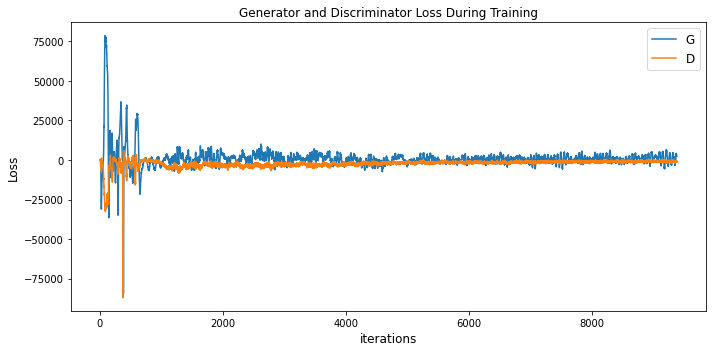

In [11]:
save_path = PATH + 'img/real_vs_fake'
plot_loss(G_losses, D_losses, save_path, save=False)

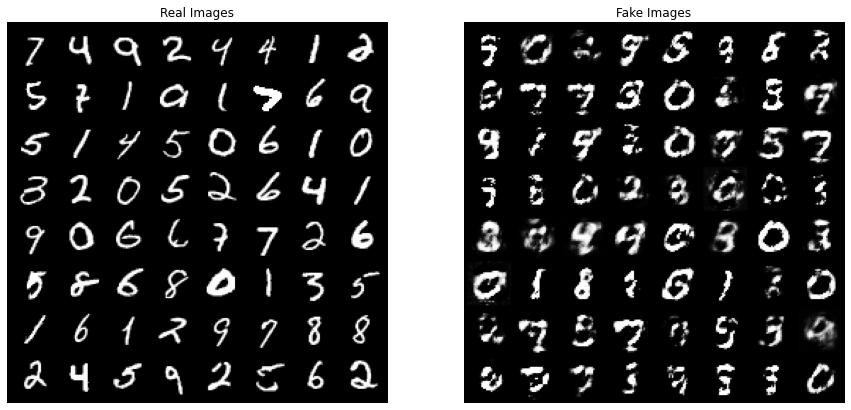

In [12]:
plot_realvsfake(dataloader, device, img_list, PATH + 'img/loss', save=False)

## G’s progression



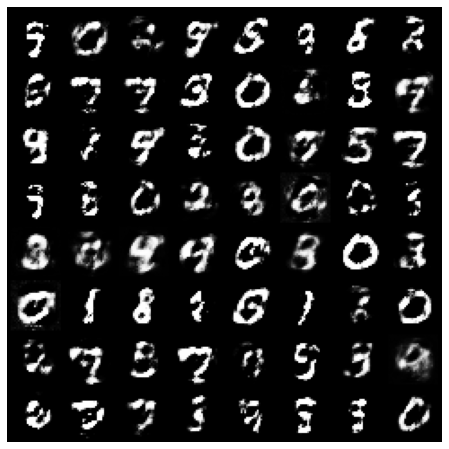

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Hyperparameter optimisation (gridsearch)

In [14]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist'  # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 2

# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 28  # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [15]:
create_repo_paths(PATH)

In [16]:
dataset, nc = get_dataset(dataset_name, image_size, dataroot)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
grid_search(ngpu, device, dataset, workers,
            experiment_prefix='',           # add an extra word at the begining to the save path of the models and stats
            batch_size_list=[128],
            shuffle_list=[True],
            num_epochs_list=[300],
            loss_name_list=['wass'],        # wass, hinge
            optimizer_name_list=['adam', 'sgd', 'rmsprop'],   # 'adam' 'sgd' 'rmsprop'
            beta1_list=[0.9],               # 0.9 == default # Beta1 hyperparam for Adam optimizers
            lr_list=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
            momentums_list=[(0, 0)],        # [(momentumD, momentumG)]
            plot=False,
            save_stats=True,                # save the stats to disk
            create_dir=True,                # create the directories to save files
            save_epochs=10,                 # save the model every save_epochs epochs
            save_models=True,               # save the models to disk
            manualSeed=123,                 # keep at 123
            nc=nc, nz=nz,
            PATH=PATH
            )